In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
df = pd.read_csv('images/fit.csv', index_col=0)
df_lum = pd.read_csv('/storeA/ryzhenenkov/lum2019.dat', sep='\t', names=['energy', 'lum', 'lum_err'], index_col='energy')
df_triggers = pd.read_csv('images/triggers.csv', index_col=0)
df = df.join(df_lum).join(df_triggers[['eff_trig', 'eff_trig_err']])
df['n0_mc'] = 20000

In [3]:
df['eff_reg'], df['eff_reg_err'] = df['n_mc']/df['n0_mc'], df['n_mc_err']/df['n0_mc']

In [4]:
df['cs_vis'] = (df['n_exp']*df['f_exp'])/(df['eff_reg']*df['eff_trig']*df['lum'])

In [28]:
df_koz = pd.read_csv('images/kozyrev.txt')
df_koz['emeas'] = df_koz['E']/2
df_koz['cs_vis'] = df_koz['cs']*df_koz['rad']

In [29]:
df_vis = pd.concat([df_koz[['emeas', 'cs_vis']], df[['emeas', 'cs_vis']]], ignore_index=True).sort_values(by='emeas')
df_vis['rad'] = 1
df_vis['cs_born'] = df_vis['cs_vis']/df_vis['rad']

In [30]:
df_vis

,emeas,cs_vis,rad,cs_born
0,502.033000,4.946400,1,4.946400
1,505.233000,30.776800,1,30.776800
2,506.477500,69.652800,1,69.652800
3,507.534000,155.866300,1,155.866300
4,508.052500,260.094300,1,260.094300
...,...,...,...,...
62,956.036438,0.157057,1,0.157057
63,962.821045,0.376070,1,0.376070
64,972.950867,0.378578,1,0.378578
65,976.210022,0.344781,1,0.344781


In [31]:
df_approx = pd.read_csv('../data/cross_sections_kskl.txt', sep=' ', index_col=0, names=['E', 'cs_born'])
df_approx['emeas'] = df_approx['E']/2
df_approx['rad'] = 1

In [32]:
from scipy.interpolate import make_interp_spline

In [34]:
df_approx

,E,cs_born,emeas,rad
2,995.0,0.000000,497.5,1
3,996.0,0.067593,498.0,1
4,997.0,0.292279,498.5,1
5,998.0,0.642567,499.0,1
6,999.0,1.128050,499.5,1
...,...,...,...,...
545,2092.0,0.368000,1046.0,1
546,2094.0,0.381000,1047.0,1
547,2096.0,0.394000,1048.0,1
548,2098.0,0.409000,1049.0,1


In [16]:
from pylib.radcors import RadCor

1	

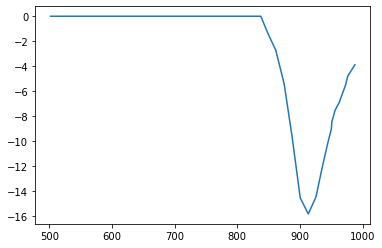

In [46]:
n_iter = 1
last = 70
for _ in range(n_iter):
    print(_+1, end='\t')
    spl = make_interp_spline(df_approx.emeas, df_approx.cs_born, k=1)
    e_interp = np.linspace(495, 1000, 3000) 
    cs_interp = spl(e_interp)
    cs_interp = np.where(e_interp<497.6, 0, cs_interp)
    cs_interp = np.where(cs_interp<0, 0, cs_interp)

    r = RadCor(e_interp, cs_interp)

    temp_rads = df_vis.rad.copy().astype('float')
    for i, j in df_vis.iterrows():
        if (i<=last):#&(i>max(0, last-5)):
            temp_rads[i] = r.F_Radcor(j['emeas'])[0]
#     if (abs(temp_rads[last]-df_vis['rad'][last])<0.05):
#         _ = n_iter-1
#         break
    if (_==(n_iter-1)):
        plt.plot(df_vis['emeas'], df_vis['rad']-temp_rads)
    
    df_vis['rad'] = temp_rads
    df_vis['cs_born'] = df_vis['cs_vis']/df_vis['rad']

In [47]:
df_vis#.head(50)

,emeas,cs_vis,rad,cs_born
0,502.033000,4.946400,0.728405,6.790727
1,505.233000,30.776800,0.728863,42.225789
2,506.477500,69.652800,0.722622,96.389037
3,507.534000,155.866300,0.713737,218.380568
4,508.052500,260.094300,0.711733,365.437876
...,...,...,...,...
62,956.036438,0.157057,8.537467,0.018396
63,962.821045,0.376070,7.892775,0.047647
64,972.950867,0.378578,6.488969,0.058342
65,976.210022,0.344781,5.803554,0.059409


<AxesSubplot:>

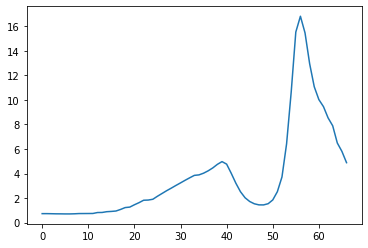

In [48]:
df_vis.rad.plot()

In [52]:
df_n = df.merge(df_vis[['emeas', 'rad']], on='emeas')

In [54]:
df_n['cs_born'] = df_n['cs_vis']/df_n['rad']

In [66]:
# df_n.to_csv('images/res19.csv')

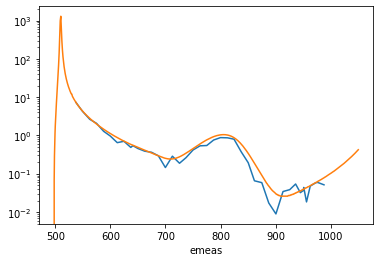

In [64]:
df_n.set_index('emeas').cs_born.plot()
plt.plot(df_approx.emeas, df_approx.cs_born)
plt.yscale('log')

Сечение

In [5]:
df = pd.read_csv('images/res19.csv', index_col=0)

In [6]:
df['nSig_exp'] = df['n_exp']*df['f_exp']
df['nSig_err'] = df['nSig_exp']*np.sqrt( (df['n_exp_err']/df['n_exp'])**2 + (df['f_exp_err']/df['f_exp'])**2 )
df['cs_born_err'] = df['cs_born']*np.sqrt( (df['nSig_err']/df['nSig_exp'])**2 + (df['eff_reg_err']/df['eff_reg'])**2 +\
                                         (df['eff_trig_err']/df['eff_trig'])**2)

Text(0.5, 0, '$\\sqrt{s}$, GeV')

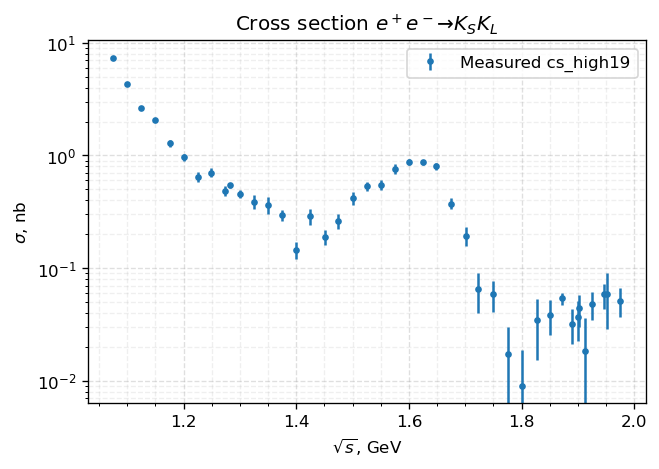

In [7]:
plt.figure(dpi=120)
plt.errorbar(df.emeas*2e-3, df.cs_born, yerr=df.cs_born_err, fmt='.', label='Measured cs_high19')
# plt.plot(df_approx.emeas*2e-3, df_approx.cs_born, label='Cross section in MC')
# plt.errorbar(df_koz.E, df_koz.cs, yerr=df_koz.cs_err, fmt='.')
# plt.xlim(520*2, 1200)
plt.grid(ls='--', alpha=0.4)
plt.grid(which='minor', ls='--', alpha=0.2)
plt.minorticks_on()
plt.legend()
plt.yscale('log')
plt.title('Cross section $e^+ e^- \\to K_S K_L$')
plt.ylabel('$\sigma$, nb')
plt.xlabel('$\sqrt{s}$, GeV');
# plt.savefig('images/cs_kskl.png', dpi=120)

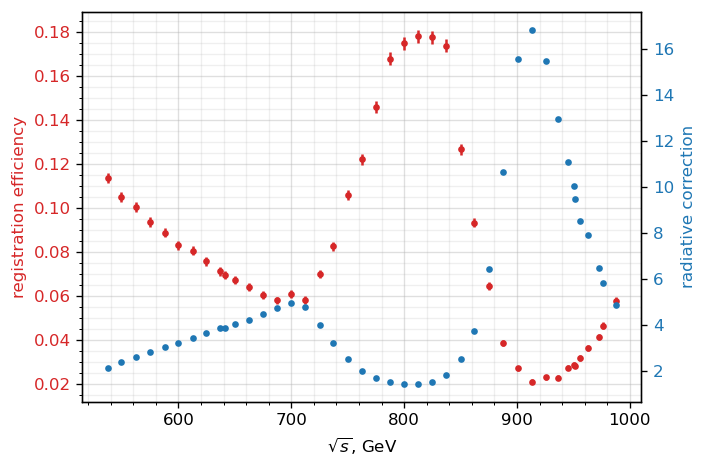

In [153]:
fig, ax1 = plt.subplots(dpi=120)

color = 'tab:red'
ax1.set_xlabel('$\sqrt{s}$, GeV')
ax1.set_ylabel('registration efficiency', color=color)
ax1.errorbar(df.emeas, df.eff_reg, yerr=df.eff_reg_err, fmt='.', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('radiative correction', color=color)  # we already handled the x-label with ax1
ax2.scatter(df.emeas, df.rad, marker='.', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.grid(alpha=0.4)
ax1.minorticks_on()
ax1.grid(which='minor', alpha=0.2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('images/rad_reg_eff.png', dpi=120)